# needed

# database with college football teams, colors, logos, game info (https://collegefootballdata.com/exporter)

# open ai key so I can use their image generation (https://www.geeksforgeeks.org/generate-images-with-openai-in-python/)

# s3 so I can save designs

 


In [2]:

from PIL import Image, ImageOps, ImageDraw, ImageFont
import numpy as np
import warnings
import requests
import pandas as pd
import json
import datetime as dt
import cfbd
import helpers as hf
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import yaml
import random
import base64
import svgwrite
from io import BytesIO

In [278]:
with open("private.yml", "r") as f:
    private_yml = yaml.safe_load(f)


head = {
"Authorization": f'Bearer {private_yml["printify_access"]}',
"Content-Type": "application/json"
}

url = "https://api.printify.com/v1/shops/13647323/products.json"


resp = requests.get(url = url, headers=head)

response = json.loads(resp.text)

In [279]:
resp.status_code

200

In [280]:
for res in response['data']:
    if res['id'] == '65a7766343833862e40ef08e':
        maybe = res


In [281]:
maybe['images']

[{'src': 'https://images-api.printify.com/mockup/65a7766343833862e40ef08e/12100/92570/middle-tennessee-vs-louisiana-tech-10-oct-2023-regular-season-week-7-pre-game.jpg?camera_label=front',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'front',
  'is_default': True,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a7766343833862e40ef08e/12100/92571/middle-tennessee-vs-louisiana-tech-10-oct-2023-regular-season-week-7-pre-game.jpg?camera_label=back',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'back',
  'is_default': False,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a7766343833862e40ef08e/12100/92572/middle-tennessee-vs-louisiana-tech-10-oct-2023-regular-season-week-7-pre-game.jpg?camera_label=person-1',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'other',
  'is_default': False,
  'is_selected_for_publishing': True},
 {'src': 'https:

In [265]:
ye = maybe['images'].copy()

In [269]:
ye[0]['is_default'] =False
ye[1]['is_default'] =True

In [273]:
url2 = f'https://api.printify.com/v1/shops/13647323/products/65a76ebb61a522e4a607e545.json'

resp = requests.put(url2, headers = head, json = ye)

In [275]:
resp.status_code

200

In [277]:
json.loads(resp.text)['title']

'Tulsa vs Temple. 28 Sep, 2023. week regular-season Week 5 post-game'

In [252]:
ye

[{'src': 'https://images-api.printify.com/mockup/65a76ebb61a522e4a607e545/12100/92570/tulsa-vs-temple-28-sep-2023-week-regular-season-week-5-post-game.jpg?camera_label=front',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'front',
  'is_default': False,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a76ebb61a522e4a607e545/12100/92571/tulsa-vs-temple-28-sep-2023-week-regular-season-week-5-post-game.jpg?camera_label=back',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'back',
  'is_default': True,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a76ebb61a522e4a607e545/12100/92572/tulsa-vs-temple-28-sep-2023-week-regular-season-week-5-post-game.jpg?camera_label=person-1',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'other',
  'is_default': False,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a76e

In [240]:
response['data'][2]['images'][0]['is_default'] = False
response['data'][2]['images'][1]['is_default'] = True

[{'src': 'https://images-api.printify.com/mockup/65a474f6689aded51102dc49/12100/92570/south-alabama-vs-southern-mississippi-17-oct-2023-week-regular-season-week-8-pre-game.jpg?camera_label=front',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'front',
  'is_default': True,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a474f6689aded51102dc49/12100/92571/south-alabama-vs-southern-mississippi-17-oct-2023-week-regular-season-week-8-pre-game.jpg?camera_label=back',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'back',
  'is_default': False,
  'is_selected_for_publishing': True},
 {'src': 'https://images-api.printify.com/mockup/65a474f6689aded51102dc49/12100/92572/south-alabama-vs-southern-mississippi-17-oct-2023-week-regular-season-week-8-pre-game.jpg?camera_label=person-1',
  'variant_ids': [12100, 12101, 12102, 12103, 12104],
  'position': 'other',
  'is_default': False,
  'is_selected_for_publishing':

In [204]:
def image_module(item):
    url_title = item["title"].replace(" ","-").replace(",","").replace(".","").lower()
    variant = 12100
    b1a = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92571/{url_title}.jpg?camera_label=back'
    b2a = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92570/{url_title}.jpg?camera_label=front'
    b3a = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92572/{url_title}.jpg?camera_label=person-1'

    variant = 12070 # other color
    b1b = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92571/{url_title}.jpg?camera_label=back'
    b2b = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92570/{url_title}.jpg?camera_label=front'
    b3b = f'https://images-api.printify.com/mockup/{item["id"]}/{variant}/92572/{url_title}.jpg?camera_label=person-1'

    new_base = [
    {'src': f'{b1a}',
    'variant_ids': [12100, 12101, 12102, 12103, 12104],
    'position': 'back',
    'is_default': True,
    'is_selected_for_publishing': True},
    {'src': f'{b2a}',
    'variant_ids': [12100, 12101, 12102, 12103, 12104],
    'position': 'front',
    'is_default': False,
    'is_selected_for_publishing': True},
    {'src': f'{b3a}',
    'variant_ids': [12100, 12101, 12102, 12103, 12104],
    'position': 'other',
    'is_default': False,
    'is_selected_for_publishing': True},

    {'src': f'{b1b}',
    'variant_ids': [12070, 12071, 12072, 12073, 12074],
    'position': 'back',
    'is_default': True,
    'is_selected_for_publishing': True},
    {'src': f'{b2b}',
    'variant_ids': [12070, 12071, 12072, 12073, 12074],
    'position': 'front',
    'is_default': False,
    'is_selected_for_publishing': True},
    {'src': f'{b3b}',
    'variant_ids': [12070, 12071, 12072, 12073, 12074],
    'position': 'other',
    'is_default': False,
    'is_selected_for_publishing': True}
    ]
    return new_base

In [205]:
old = item.copy()
old["images"][0]["is_default"] = False
old["images"][1]["is_default"] = True

old["images"][12]["is_default"] = False
old["images"][13]["is_default"] = True

url2 = f'https://api.printify.com/v1/shops/13647323/products/{item["id"]}.json'

all_var_images = image_module(item)

new = {"images": all_var_images}

resp = requests.put(url2, headers = head, data = new)

In [209]:
set([all_var_images[x]['src'].split('/')[5] for x in range(len(all_var_images))])

{'12070', '12100'}

In [206]:
len(json.loads(resp.text)["images"])

24

In [208]:
set([ json.loads(resp.text)["images"][x]['src'].split('/')[5] for x in range(len(json.loads(resp.text)["images"]))])

{'12070', '12100'}

In [4]:
def process_game(game,teams,design_config,s3_mover,game_id,test,shop_config,pref):
    game = game.to_dict('records')[0]
    game_config = hf.parse_game(game,teams)
    game_config['game_id'] = game
    config = hf.combine_configs(design_config,game_config)
    design,text = hf.build_design(config,test=False)

    # do I need to save all my images to s3?
    s3_mover.image_to_s3(design,rf"{pref}/{game_config['home_team']['shortn']}_v_{game_config['away_team']['shortn']}_{game_id}")

    if not test:
        title,description,tags=hf.generate_t_d_t(game_config)
        shop_config['image'] = design
        shop_config['title'] = title
        shop_config['description'] =  description
        shop_config['tags'] =  tags
        shop_config['design'] = design
        shop_config['text'] = text
        hf.post(shop_config,publish=True)

In [11]:
import time

In [9]:
monday_run(test=False,specific_game=401551788)

artificially setting to monday past date
New games to do 0
Upcoming games to do 1
upcoming games
    generating game image
NCAA football University Of Washington Huskies mascot beating University Of Texas Longhorns mascot
using saved image because test mode
image and text sent to printify
Product posted successfully in Printify
Product published successfully in Printify
['postseason1']
got all items
filtered list for just this collection
collection created


- handle nan in teams table
- font auto sizing

In [66]:
all_games_df = pd.read_csv(r'/Users/loganmckerlich/Downloads/all_games_2023 __.csv',index_col=0)
all_games_df.startdate = pd.to_datetime(all_games_df.startdate)
all_games_df = all_games_df.drop_duplicates()
all_games_df['monday'] = all_games_df['startdate'] - all_games_df['startdate'].dt.weekday.astype('timedelta64[D]')
all_games_df.monday = all_games_df.monday.apply(lambda x:x.date())
all_games_df.startdate = all_games_df.startdate.apply(lambda x:x.date())
all_games_df.game_type = np.where(all_games_df.game_type=='regular', 'regular-season',all_games_df.game_type)
all_games_df.week = all_games_df['game_type']+' Week '+all_games_df['week'].astype(str)

In [67]:
all_games_df.game_type.unique()

array(['regular-season', 'postseason'], dtype=object)

In [68]:
all_games_df.week.unique()

array(['regular-season Week 1', 'regular-season Week 2',
       'regular-season Week 3', 'regular-season Week 4',
       'regular-season Week 5', 'regular-season Week 6',
       'regular-season Week 7', 'regular-season Week 8',
       'regular-season Week 9', 'regular-season Week 10',
       'regular-season Week 11', 'postseason Week 11',
       'regular-season Week 12', 'postseason Week 12',
       'regular-season Week 13', 'postseason Week 13',
       'regular-season Week 14', 'postseason Week 14',
       'postseason Week 15', 'regular-season Week 15',
       'postseason Week 1'], dtype=object)

In [10]:
## DALLE
import yaml
from PIL import Image
import requests
with open("private.yml", "r") as f:
    private_yml = yaml.safe_load(f)
dalle = private_yml['dalle_key']

In [2]:
from openai import OpenAI
client = OpenAI(api_key=dalle)

def dalle_image(client,prompt):
    print('This cost you 4 cents')
    response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    size="1024x1024",
    quality="standard",
    n=1,
    )

    image_url = response.data[0].url

    d = Image.open(requests.get(image_url, stream=True).raw)
    return d

In [4]:
first_dall = dalle_image(client,'University of Houston Cougars Mascot dancing at a party')

This cost you 4 cents


In [11]:
d = Image.open(requests.get(first_dall, stream=True).raw)

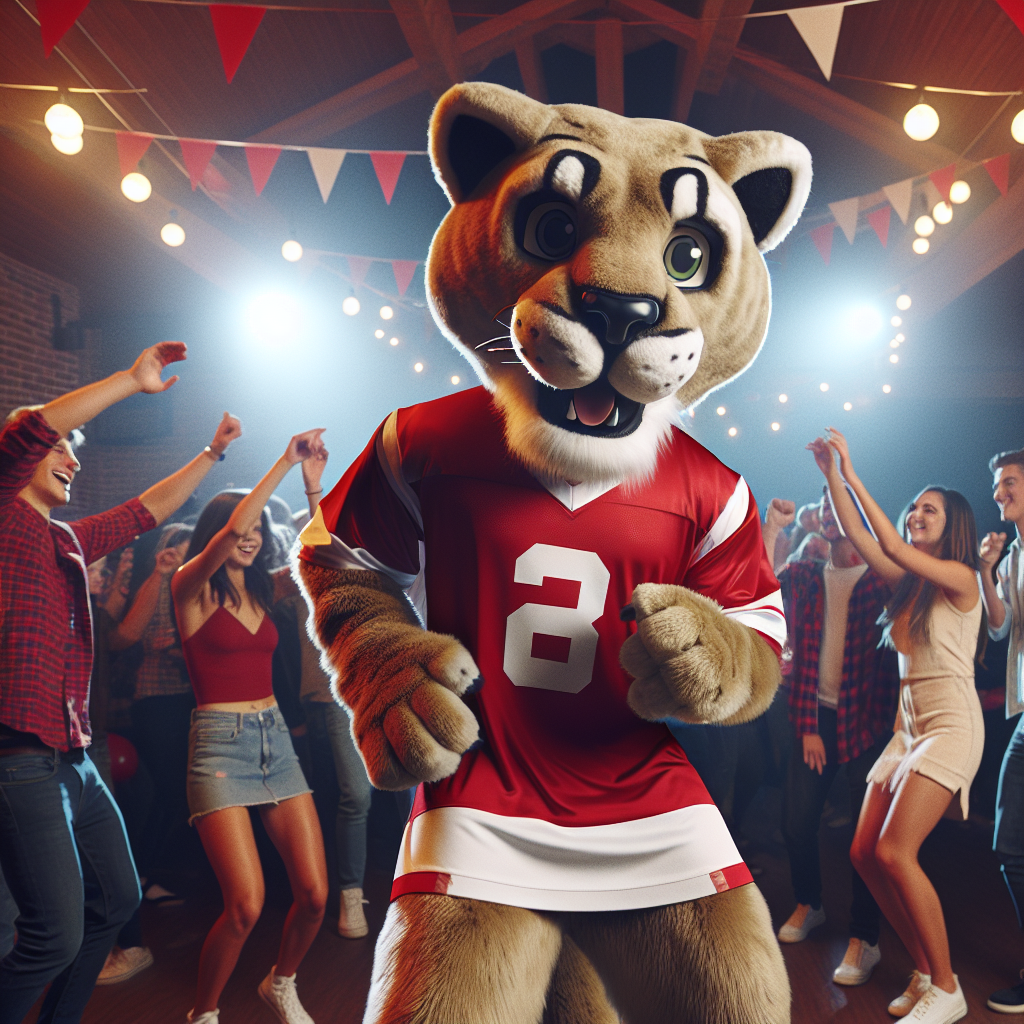

In [12]:
d

In [1]:
'title name woo'

'Title Name Woo'

In [7]:
int(float('2199.0'))

2199